In [2]:
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt

In [5]:
tf.__version__

'2.18.0'

In [6]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist()
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 5616.86file/s]

Finished extracting file
Finished extracting file


In [7]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
parh = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   validation_split=val_split,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                 validation_split=val_split)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [9]:
train_generator = train_datagen.flow_from_directory(
    directory = parh,
    seed = seed,
    batch_size = batch_size,
    shuffle = True,
    target_size = (img_rows, img_cols),
    class_mode = 'binary',
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [10]:
val_generator = val_datagen.flow_from_directory(
    directory = parh,
    seed = seed,
    batch_size = batch_size,
    shuffle = True,
    target_size = (img_rows, img_cols),
    subset = 'validation',
    class_mode = 'binary'
    )

Found 200 images belonging to 2 classes.


In [11]:
test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)


Found 200 images belonging to 2 classes.


In [12]:
print(len(train_generator))


25


Labels: [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]


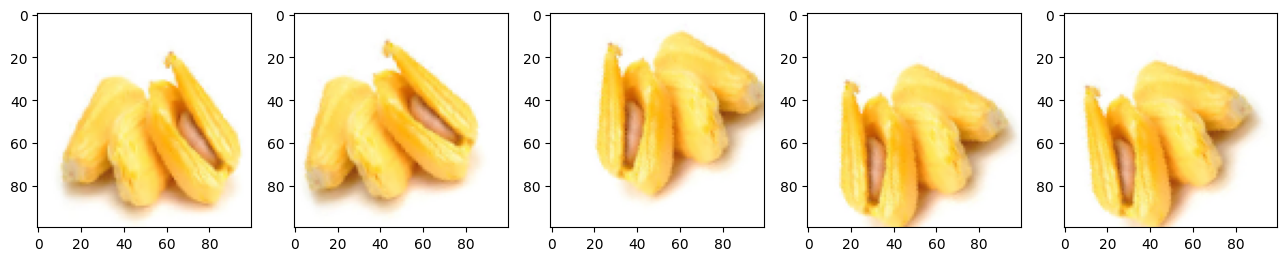

In [13]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1],
                                 train_labels[img_id:img_id+1],
                                 batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

In [14]:
#VGG-16
from tensorflow.keras.applications import VGG16
input_shape = (150, 150, 3)
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
output = vgg_conv.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = tf.keras.Model(inputs=vgg_conv.input, outputs=output)

In [16]:
#freeze the basemodel
for layer in basemodel.layers:
  layer.trainable = False

In [17]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [18]:
#Task 4
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [19]:
for layer in basemodel.layers:
  layer.trainable = False

model.compile(
  loss='binary_crossentropy',
  optimizer=optimizers.RMSprop(learning_rate=1e-4),
  metrics=['accuracy']
)

In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler

checkpoint_path='O_R_tlearn_vgg16.keras'

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.epochs = []  # Initialize epochs list

    def on_epoch_end(self, epoch, logs={}):  # Add epoch as argument
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))
        self.epochs.append(epoch)  # Append epoch to the list

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

loss_history = LossHistory()
lrate = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history, lrate] + keras_callbacks


In [21]:
extract_feat_model = model.fit(train_generator,
                               steps_per_epoch=5,
                               epochs=10,
                               callbacks = callbacks_list_,
                               validation_data=val_generator,
                               validation_steps=val_generator.samples // batch_size,
                               verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4220 - loss: 0.8528lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 791ms/step - accuracy: 0.4277 - loss: 0.8450 - val_accuracy: 0.6250 - val_loss: 0.6167 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7330 - loss: 0.5916lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7369 - loss: 0.5880 - val_accuracy: 0.7760 - val_loss: 0.5388 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7025 - loss: 0.5511lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step - accuracy: 0.7073 - loss: 0.5494 - val_accuracy: 0.7865 - val_loss: 0.5038 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7315 - loss: 0.4910lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.7304 - loss: 0.4940 - val_accuracy: 0.8073 - val_loss: 0.4666 - learning_rate: 7.4082

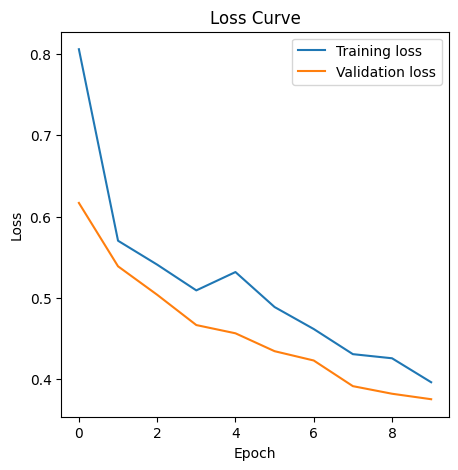

In [22]:
history = extract_feat_model

plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

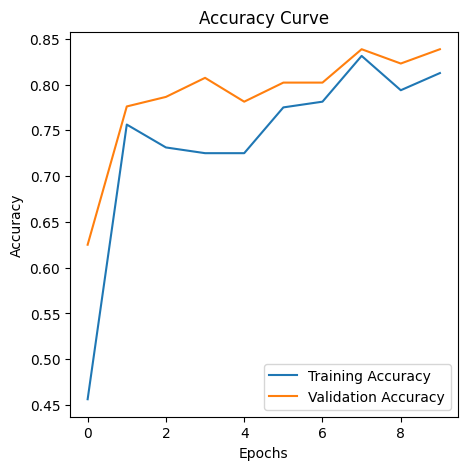

In [23]:
#extract feat model
#Task 6
history = extract_feat_model
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [24]:
#fine-tuning

from tensorflow.keras.applications import VGG16
input_shape = (150, 150, 3)
vgg_conv = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=input_shape)

output = vgg_conv.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = tf.keras.Model(inputs=vgg_conv.input, outputs=output)


for layer in basemodel.layers:
  layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
  if layer.name == 'block5_conv3':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in basemodel.layers:
  print(f'{layer.name}: {layer.trainable}')

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


In [25]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

loss_history_ = LossHistory()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator,
                            steps_per_epoch=5,
                            epochs=10,
                            callbacks = callbacks_list_,
                            validation_data=val_generator,
                            validation_steps=val_generator.samples // batch_size,
                            verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5798 - loss: 0.7048lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 757ms/step - accuracy: 0.5852 - loss: 0.6992 - val_accuracy: 0.7865 - val_loss: 0.5539 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.6642 - loss: 0.6084lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - accuracy: 0.6712 - loss: 0.6027 - val_accuracy: 0.6354 - val_loss: 0.5632 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7125 - loss: 0.5716lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - accuracy: 0.7135 - loss: 0.5665 - val_accuracy: 0.8333 - val_loss: 0.4438 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7664 - loss: 0.4578lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.7699 - loss: 0.4545 - val_accuracy: 0.8438 - val_loss: 0.4054 - learning_rate: 7.4

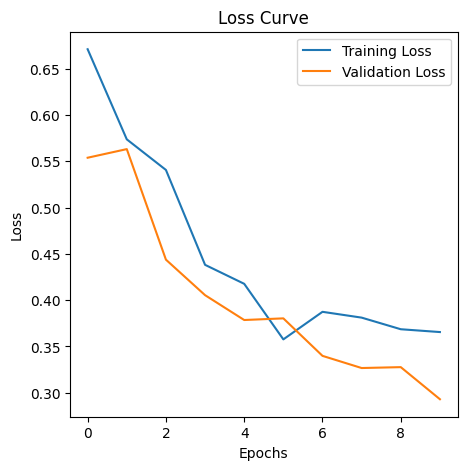

In [26]:
#Task 7
history = fine_tune_model
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


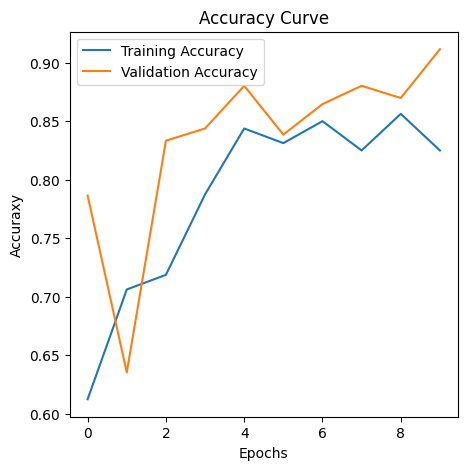

In [27]:
#Task 8
history = fine_tune_model
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuraxy')
plt.legend()
plt.show()

In [28]:
#evaluation

from pathlib import Path

extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.85      0.68      0.76        50
           R       0.73      0.88      0.80        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.88      0.84      0.86        50
           R       0.85      0.88      0.86        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



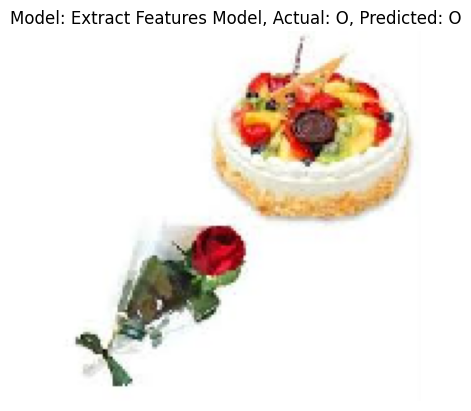

In [29]:
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

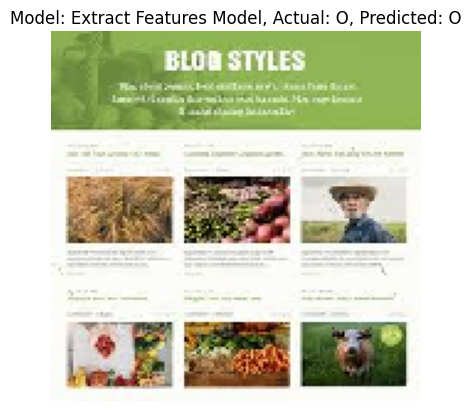

In [30]:
#Task 9
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

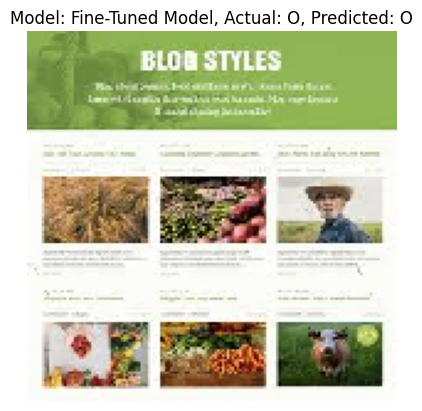

In [31]:
#Task 10
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_fine_tune_model[index_to_plot],
    )
